<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

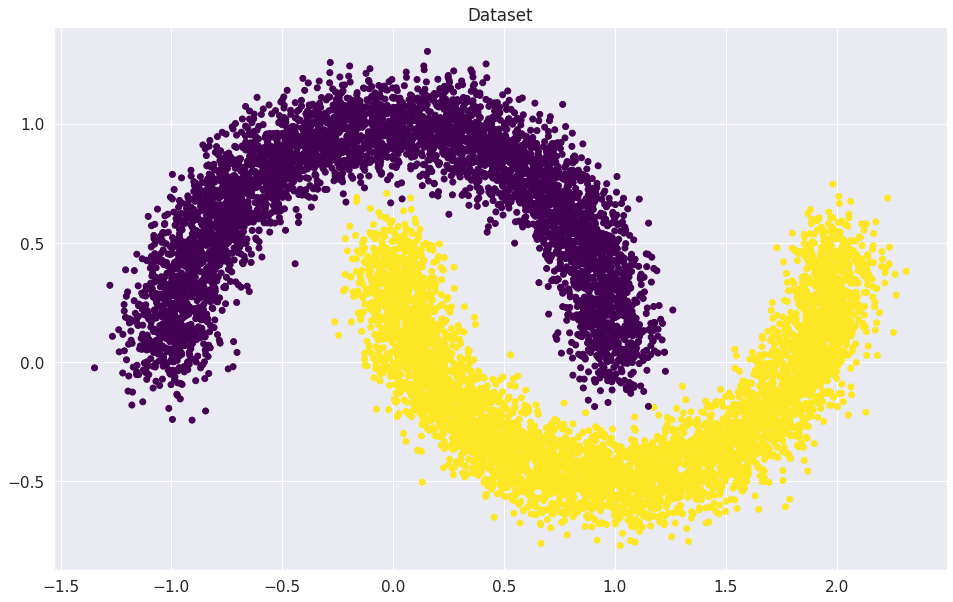

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t =  torch.FloatTensor(X_train)
y_train_t =  torch.FloatTensor(y_train)
X_val_t =  torch.FloatTensor(X_val)
y_val_t =  torch.FloatTensor(y_val)

Создаем `Dataset` и `DataLoader`. 

In [6]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [7]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn((in_features, out_features)))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        logits = x @ self.weights
        if self.bias:
            logits += self.bias_term
        return logits

In [8]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели?

In [9]:
list(linear_regression.parameters())

[Parameter containing:
 tensor([[-0.4466],
         [ 0.0675]], requires_grad=True), Parameter containing:
 tensor([-1.2209], requires_grad=True)]

**Ответ:** 3

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [10]:
def sigmoid_t(x: torch.Tensor):
    return 1 / (1 + torch.exp(-x)) 

In [11]:
def sigmoid_np(x: np.array):
    return 1 / (1 + np.exp(-x)) 

In [12]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch)
        loss =  loss_function(outp, y_batch[:, None])
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities =  sigmoid_t(outp)
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            answer2 = it + epoch * len(train_dataloader)
            print(f"\nIteration: {answer2}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.515625
Iteration: 100
Batch accuracy: 0.796875
Iteration: 200
Batch accuracy: 0.8046875
Iteration: 300
Batch accuracy: 0.8828125
Iteration: 400
Batch accuracy: 0.8515625
Iteration: 500
Batch accuracy: 0.8984375
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.828125
Iteration: 800
Batch accuracy: 0.84375

Iteration: 814.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

In [13]:
print('Ответ:', answer2)

Ответ: 814


### Визуализируем результаты

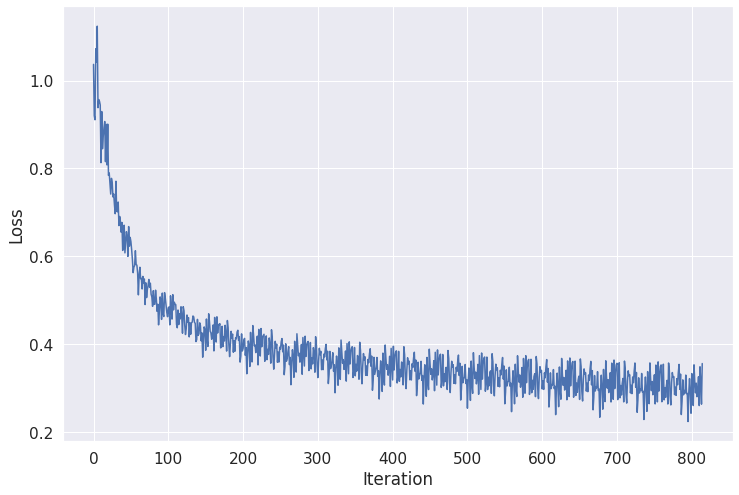

In [14]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

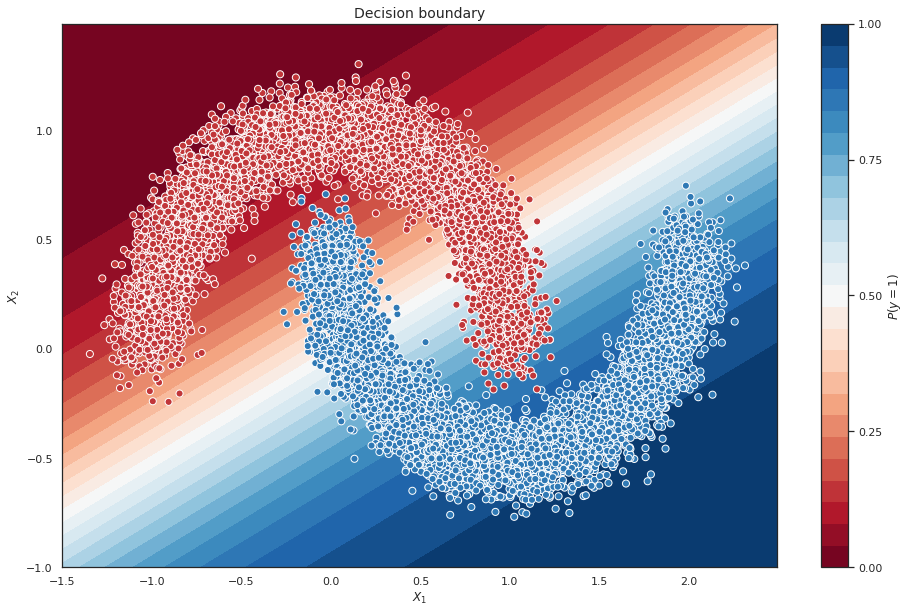

In [15]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [16]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        preds = model(x_batch)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [17]:
from sklearn.metrics import accuracy_score
y_pred = (sigmoid_np(predict(val_dataloader, linear_regression)) > 0.5).astype(int)
y_true = np.array([])
for _, y_tr in val_dataloader:
    y_true = np.hstack((y_true, y_tr.numpy().flatten()))
answer3 = accuracy_score(y_true, y_pred)

**Вопрос 3**

Какое `accuracy` получается после обучения?

In [18]:
print('Ответ: ', answer3)

Ответ:  0.8608


# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [19]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_dataloader =  torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [22]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [3]:
 
device

device(type='cpu')

In [4]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 128),
    activation(),
    nn.Linear(128, 128),
    activation(),
    nn.Linear(128, 10)
).to(device)

In [8]:
model[:5]

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ELU(alpha=1.0)
)

In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [43]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    print(f"Epoch: {epoch+1}")
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                # Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                # Calculate gradients and make a step of your optimizer
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
            else:
                # Set model to ``eval`` mode and calculate outputs
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum()
            all =  torch.numel(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8863166666666666
Loader: valid. Accuracy: 0.9372
Epoch: 2
Loader: train. Accuracy: 0.9476666666666667
Loader: valid. Accuracy: 0.9561
Epoch: 3
Loader: train. Accuracy: 0.9634833333333334
Loader: valid. Accuracy: 0.9662
Epoch: 4
Loader: train. Accuracy: 0.9710833333333333
Loader: valid. Accuracy: 0.9697
Epoch: 5
Loader: train. Accuracy: 0.97555
Loader: valid. Accuracy: 0.9712
Epoch: 6
Loader: train. Accuracy: 0.9789333333333333
Loader: valid. Accuracy: 0.9726
Epoch: 7
Loader: train. Accuracy: 0.98195
Loader: valid. Accuracy: 0.9749
Epoch: 8
Loader: train. Accuracy: 0.9837333333333333
Loader: valid. Accuracy: 0.9776
Epoch: 9
Loader: train. Accuracy: 0.98665
Loader: valid. Accuracy: 0.9714
Epoch: 10
Loader: train. Accuracy: 0.9864666666666667
Loader: valid. Accuracy: 0.9742


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [45]:
elu_accuracy = accuracy["valid"]
elu_accuracy

[0.9372,
 0.9561,
 0.9662,
 0.9697,
 0.9712,
 0.9726,
 0.9749,
 0.9776,
 0.9714,
 0.9742]

In [52]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation, verbose=False):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    device = torch.device(device)
    
    if verbose:
        print(device)
        print(activation)
    
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, 10)
    ).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    
    max_epochs = 10
    accuracy = []
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                if k == "train":
                    # Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
                    # Calculate gradients and make a step of your optimizer
                    loss = criterion(outp, y_batch)
                    loss.backward()
                    optimizer.step()
                else:
                    # Set model to ``eval`` mode and calculate outputs
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                    
                    preds = outp.argmax(-1)
                    correct =  (preds == y_batch).sum()
                    all =  torch.numel(y_batch)
                    epoch_correct += correct.item()
                    epoch_all += all
            if k == 'valid':
                if verbose:
                    print(epoch_correct/epoch_all)
                accuracy.append(epoch_correct/epoch_all)
    return accuracy

In [53]:
plain_accuracy = test_activation_function(Identical, verbose=True)
relu_accuracy = test_activation_function(nn.ReLU, verbose=True)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU, verbose=True)
# elu_accuracy = test_activation_function(nn.ELU)

cuda:0
<class '__main__.Identical'>
0.9039
0.9142
0.9079
0.9108
0.9134
0.9153
0.9145
0.9181
0.9188
0.9137
cuda:0
<class 'torch.nn.modules.activation.ReLU'>
0.9341
0.9539
0.9553
0.9665
0.9674
0.9724
0.9718
0.9749
0.9689
0.9725
cuda:0
<class 'torch.nn.modules.activation.LeakyReLU'>
0.9345
0.9464
0.9589
0.9652
0.9646
0.9711
0.9758
0.9684
0.9722
0.9735


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

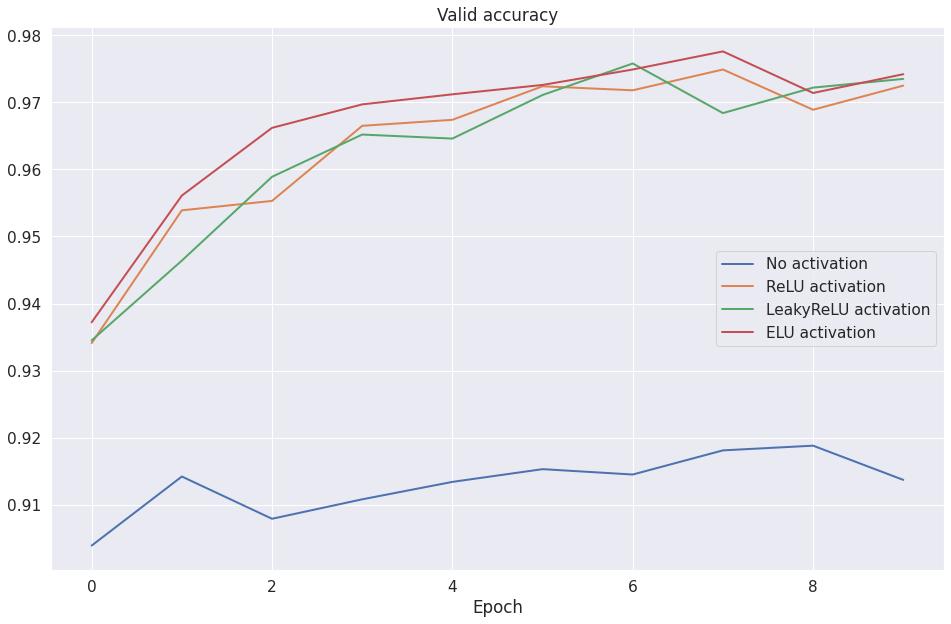

In [54]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

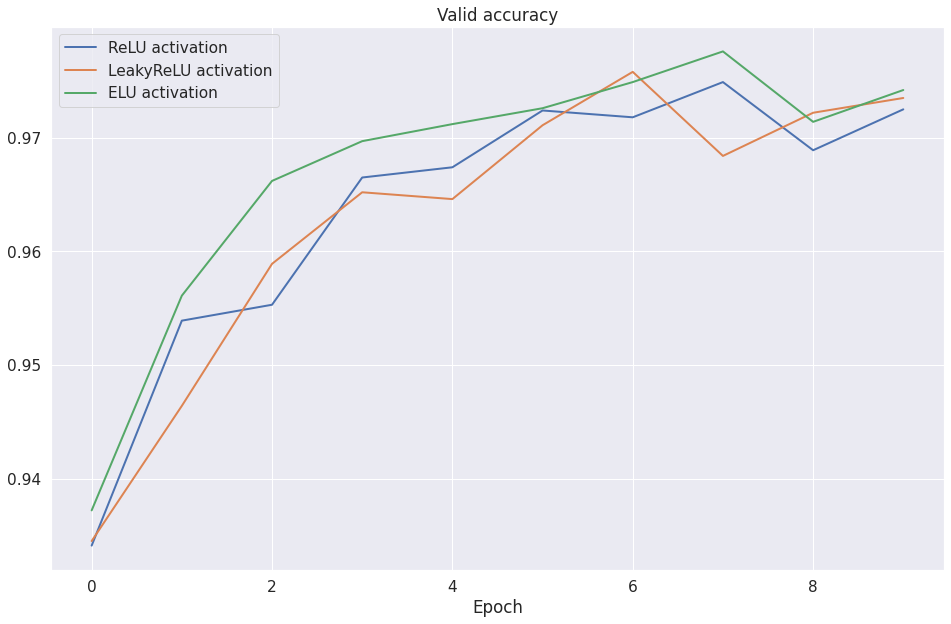

In [55]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** В основном **ELU**, но один раз получил LeakyReLU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [56]:
!wget --no-check-certificate https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2021-11-07 08:00:34--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2021-11-07 08:00:35--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   219KB/s    in 0.2s    

2021-11-07 08:00:35 (219 KB/s) - ‘sample_photo.jpg’ saved [49337/4

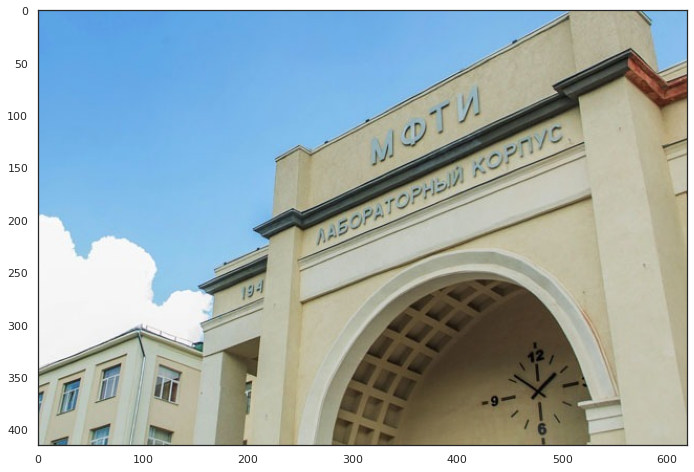

In [57]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте

A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [58]:
kernels = dict()
kernels['А'] = torch.tensor([[0, 0, 0], [0, 1, 0], [0, 0, 0]])
kernels['Б'] = torch.tensor([[0, 1, 0], [0, -2, 0], [0, 1, 0]])
kernels['В'] = torch.tensor([[0, 0, 0], [1, -2, 1], [0, 0, 0]])
kernels['Г'] = torch.tensor([[0, 1, 0], [1, -4, 1], [0, 1, 0]])
kernels['Д'] = torch.tensor([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
kernels['Е'] = torch.tensor([[0.0625, 0.125, 0.0625], [0.125, 0.25, 0.125], [0.0625, 0.125, 0.0625]])
# kernels['Ж'] = torch.tensor([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
kernels

{'А': tensor([[0, 0, 0],
         [0, 1, 0],
         [0, 0, 0]]), 'Б': tensor([[ 0,  1,  0],
         [ 0, -2,  0],
         [ 0,  1,  0]]), 'В': tensor([[ 0,  0,  0],
         [ 1, -2,  1],
         [ 0,  0,  0]]), 'Г': tensor([[ 0,  1,  0],
         [ 1, -4,  1],
         [ 0,  1,  0]]), 'Д': tensor([[ 0, -1,  0],
         [-1,  5, -1],
         [ 0, -1,  0]]), 'Е': tensor([[0.0625, 0.1250, 0.0625],
         [0.1250, 0.2500, 0.1250],
         [0.0625, 0.1250, 0.0625]])}

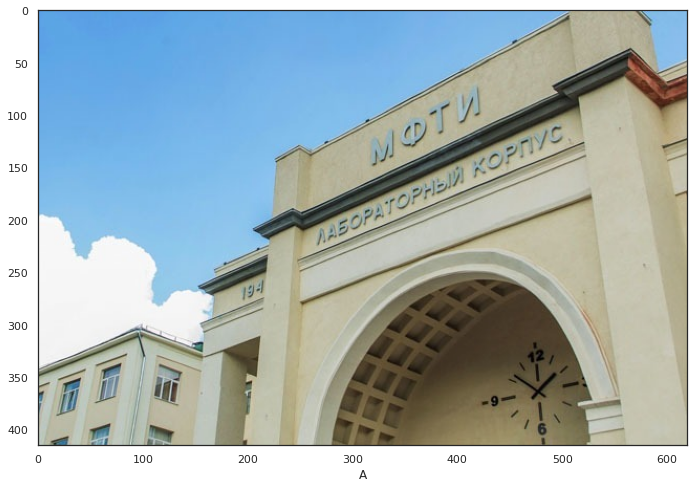

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


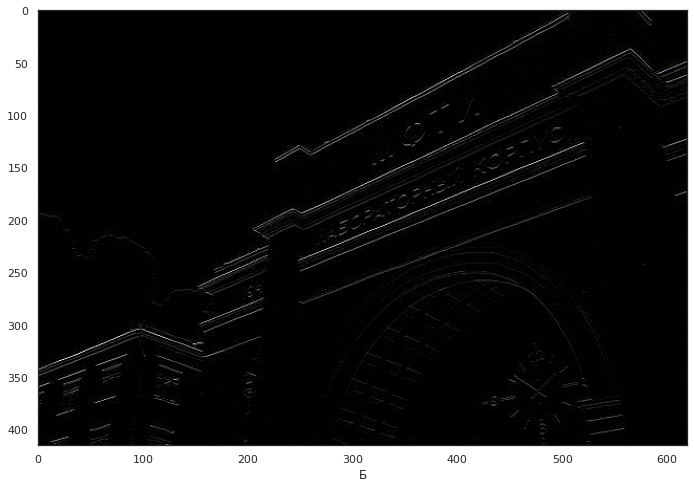

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


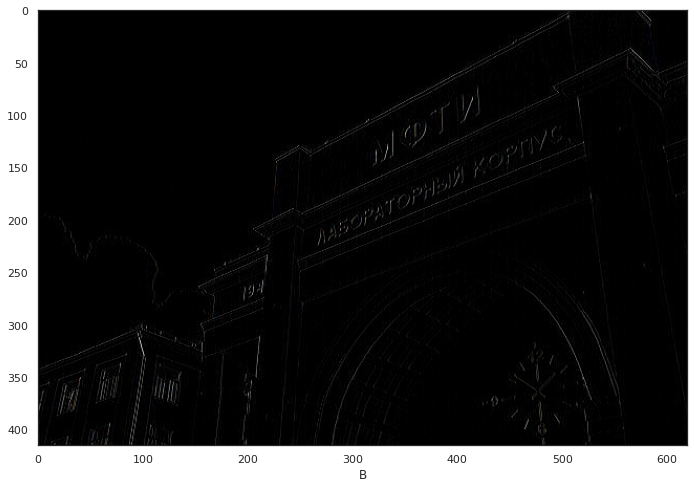

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


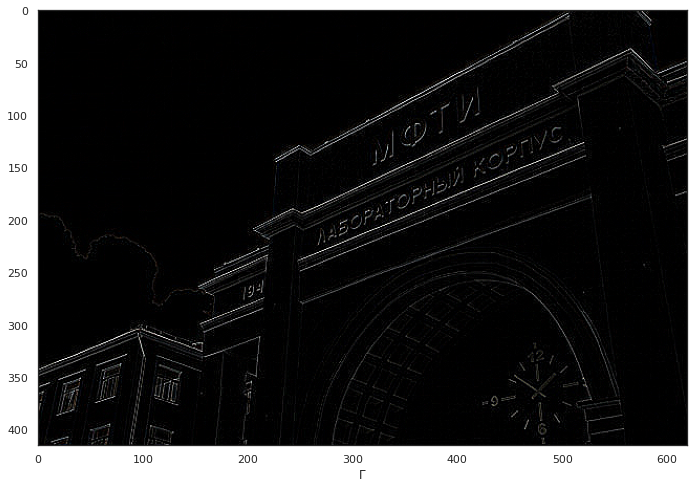

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


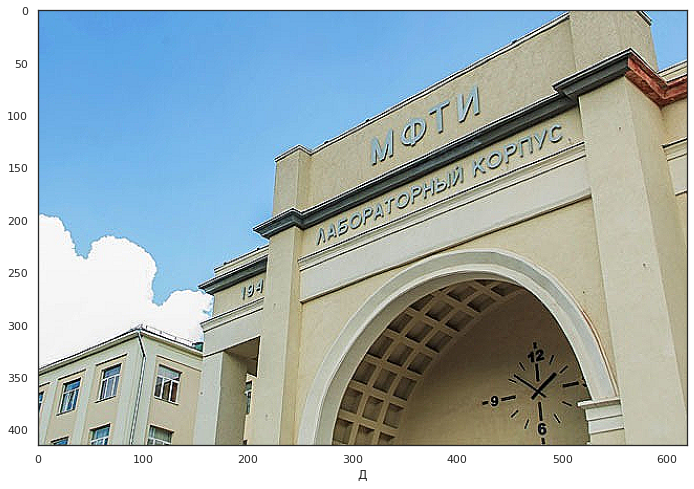

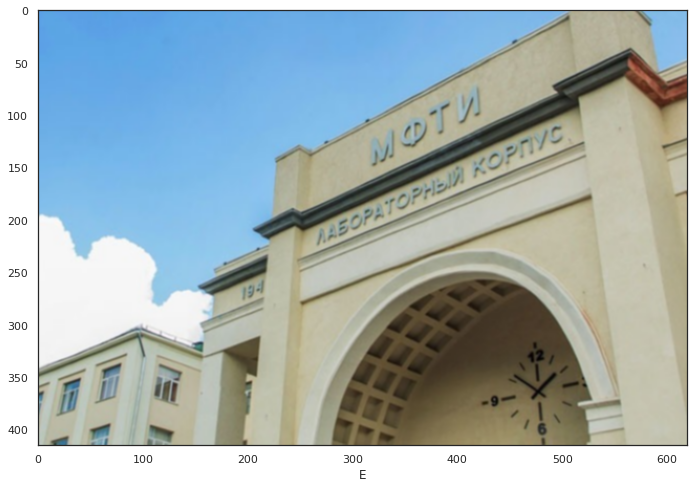

In [59]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
img_t = img_t.permute(3, 0, 1, 2)
img_t = nn.ReflectionPad2d(1)(img_t)

for letter, kernel in kernels.items():
    kernel = kernel.reshape(1, 1, 3, 3).type(torch.float32)

    div = kernel.sum().item()
    if div == 0:
        div = 1

    result = F.conv2d(img_t, kernel)
    result = (result.squeeze().permute(1, 2, 0).numpy() / div).astype(np.int)

    plt.figure(figsize=(12, 8))
    plt.imshow(result)
    plt.xlabel(letter)
    plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:** 1-Е 2-Д 3-А 4-В 5-Б 6-Г

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [60]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(5 * 5 * 16, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [61]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [62]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    print(f"Epoch: {epoch+1}")
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            if k == "train":
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()
            else:
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum()
            all =  torch.numel(y_batch)
            epoch_correct += correct.item()
            epoch_all += all
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Loader: train. Accuracy: 0.8899166666666667
Loader: valid. Accuracy: 0.9656
Epoch: 2
Loader: train. Accuracy: 0.9702166666666666
Loader: valid. Accuracy: 0.9799
Epoch: 3
Loader: train. Accuracy: 0.9796666666666667
Loader: valid. Accuracy: 0.9834
Epoch: 4
Loader: train. Accuracy: 0.9844333333333334
Loader: valid. Accuracy: 0.9872
Epoch: 5
Loader: train. Accuracy: 0.9868166666666667
Loader: valid. Accuracy: 0.9892
Epoch: 6
Loader: train. Accuracy: 0.9893833333333333
Loader: valid. Accuracy: 0.9877
Epoch: 7
Loader: train. Accuracy: 0.9907666666666667
Loader: valid. Accuracy: 0.9886
Epoch: 8
Loader: train. Accuracy: 0.9922
Loader: valid. Accuracy: 0.9896
Epoch: 9
Loader: train. Accuracy: 0.9933333333333333
Loader: valid. Accuracy: 0.9899
Epoch: 10
Loader: train. Accuracy: 0.9936666666666667
Loader: valid. Accuracy: 0.99


In [63]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

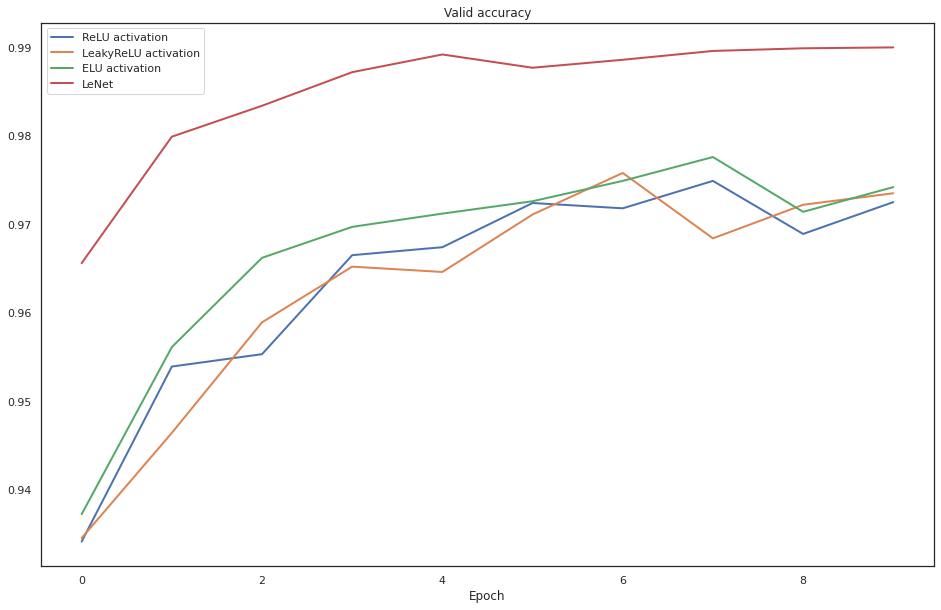

In [64]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

In [67]:
print('Ответ:',round(lenet_accuracy[max_epochs-1], 2))

Ответ: 0.99
